In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm

from covid_data_helper import *
from coronita_model_helper import *
from coronita_chart_helper import *

In [2]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

df_counties = get_complete_county_data()

counties_geo = get_counties_geo()

df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

df_interventions = get_state_policy_events()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')

#######################

### RUN MODEL ###
df_fore_allstates = pd.DataFrame()

try:
    df_prevfore_allstates = pd.read_pickle('./output/df_fore_allstates_{}.pkl'.format(
        (pd.Timestamp.today() - pd.Timedelta(days=1)).strftime("%Y%m%d")))
except:
    if 'df_fore_allstates' in globals().keys():
        if df_fore_allstates.shape[0] > 0:
            df_prevfore_allstates = df_fore_allstates.copy()

State Testing Data Last Observation:  20200825
Got COVID19 Tracking Data
Got Census Data
Got NYS DOH data
Got Census Data
Got NYT county level data.
Got Google Movement Data
Got Complete County Data
Got counties geo json
Got JHU county level data.
Got KFF Policy dates
Got Google Movement Data


WY
Best starting date:  2020-03-13 00:00:00
Peak Hospitalization Date:  23 Aug, 2020
Peak Hospitalization #: 25
Peak ICU #: 8
Peak Ventilator #: 3


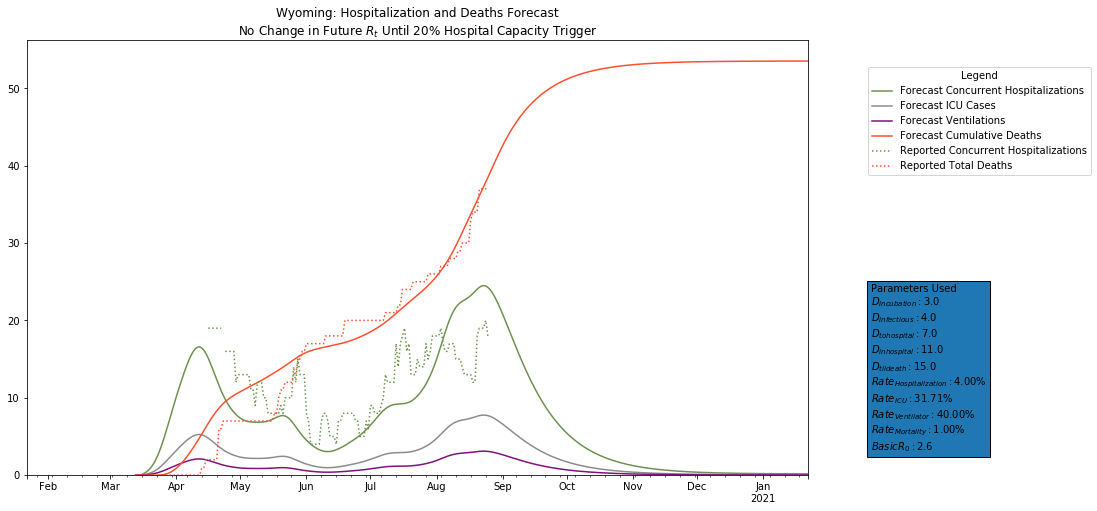

In [14]:
## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
# covid_params['hosp_rt'] = 0.05
# covid_params['mort_rt'] = covid_params['hosp_rt']/(27.18328/10) # 0.0184
covid_params['mort_rt'] = 0.01
covid_params['hosp_rt'] = 0.04 #27.18328/10*covid_params['mort_rt']
covid_params['d_in_hosp'] = 11
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 17.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  15
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True
days_to_forecast = 150

#######################

allstate_model_dicts = {}
df_rts_allregs = pd.DataFrame()
df_wavg_rt_conf_allregs = pd.DataFrame()

for state in ['WY']: #df_census.state.unique():
    print(state)
    
    model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt,
                                       covid_params, days_to_forecast,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )

    this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[state])
    this_reg_df_wavg = pd.DataFrame(
        model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[state])

    df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
    df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

    try:
        first_guess = df_prevfore_allstates[state].first_valid_index()[0]
    except:
        first_guess = pd.Timestamp('2020-02-17')

    model_dict = model_find_start(first_guess, model_dict)
    df_agg = model_dict['df_agg']
    df_all_cohorts = model_dict['df_all_cohorts']

    print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
    print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
    print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
    print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))

    allstate_model_dicts[state] = model_dict
    df_fore_allstates = pd.concat([df_fore_allstates,pd.DataFrame(df_agg.stack(), columns=[state])], axis=1)

    model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'

    ax = ch_hosp(model_dict)
    plt.show()

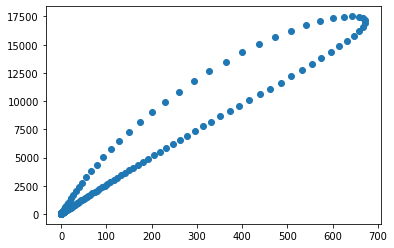

In [59]:
plt.scatter(model_dict['df_agg']['deaths'].diff(), model_dict['df_agg']['hospitalized'])

In [133]:
new_ratio = 5.1
old_ratio = 4/2 == 2

In [151]:
4/(4/5.1)

5.1

In [134]:
(ratio/4-1)/2+1

1.125

In [137]:
1.125**-1

0.8888888888888888

In [135]:
4*((ratio/4-1)/2+1)/ratio

0.9

In [136]:
4*((ratio/4-1)/2+1)/(4*((ratio/4-1)/2+1)/ratio)

5.0

In [5]:
np.polyfit(model_dict['df_agg']['deaths'].dropna().diff().fillna(0), 
           model_dict['df_agg']['hospitalized'].dropna(), 1)

KeyError: 'df_agg'

In [13]:
model_dict['df_hist']['deaths_daily'].mean()

0.24503311258278146

array([ 1.05580774, 11.83284379])

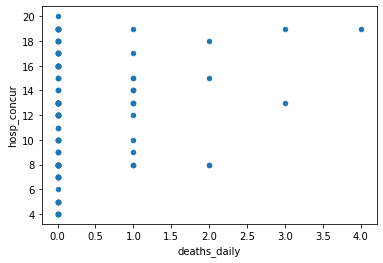

In [6]:
model_dict['df_hist'].plot.scatter('deaths_daily','hosp_concur')
test = model_dict['df_hist'][['deaths_daily','hosp_concur']].dropna()
np.polyfit(test['deaths_daily'], 
           test['hosp_concur'], 1)


In [7]:
np.linalg.lstsq(test['deaths_daily'].values.reshape(-1,1), test['hosp_concur'])[0][0]

/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


7.1515151515151505